In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.fft import fft, fftfreq
from math import pi 
from scipy import stats 
from scipy import special

In [12]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.normal(0, 1, N_train)
    y_train = f(x_train)
    
    x_validation = np.random.normal(0, 1, N_train)
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    y_test = f(x_test)
    
    plt.plot(x_test, y_test)
    plt.title('y_test')
    plt.show()
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [13]:
# compute cut-off frequency w0

def method_1_w0(x, y, px): 
    
    # calculate f_p
    dx = x[1] - x[0]
    E_y = np.sum(px * y * dx)
    fp = np.sqrt(px) * (y - E_y)

    # fast Fourier transform
    N = len(x)
    yf = np.fft.fft(fp, axis=0)
    #xf = fftfreq(N,dx)[:N//2]
    #plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    #plt.title("Fourier transform")
    #plt.show()
    
    # the minimization function 
    dw = 2*pi/N/dx 
    K = np.linspace(-N/2, N/2-1, N)
    # K = np.reshape(K, (N,1))
    # yf = np.reshape(yf, (N+1,1))
    f2 = np.abs(yf * dx)**2 * dw
    #plt.plot(K,f2)
    #plt.title("the minimization function")
    #plt.show()
    
    
    # compute the difference 
    var_f = np.sum(f2)
    n0 = range(0, int(N/2))
    e_diff = np.zeros(int(N/2))
    
    for k in n0:
        if k>=0 and k<=N/2-1: 
            if k==0: 
                e_low = f2[k]
                e_high = var_f - e_low
            else:
                e_low = f2[0] + 2*np.sum(f2[1:k])
                e_high = var_f - e_low
            e_diff[k] = np.abs(e_low-e_high)
        else: 
            print("index error")

    #plt.plot(n0, e_diff)
    #plt.title("e_low - e_high")
    #plt.show()

    #plt.plot(n0, e_diff)
    #plt.title("e_low - e_high")
    #plt.xlim(0,100)
    #plt.show()
    
    # calculate the cut-off w0
    e_diff_min = min(e_diff)
    w0 = np.argmin(e_diff) 
    # print(w0)
    
    return w0, var_f

In [14]:
def method_1(var_f, w0, x_test, y_test, pred, px): 
    
    N = len(x_test) 
    # compute r
    r = y_test - pred

    #plt.plot(x_test, y_test, color='black', label = 'y_test')
    #plt.plot(x_test, pred, color='green', label = 'predict')
    #plt.plot(x_test, r, color='red', label = 'residual')
    #plt.title("data fitting")
    #plt.legend()
    #plt.show()

    # calculate r_p
    dx = x_test[1] - x_test[0]
    r_mean = np.sum(px * r * dx)
    rp = np.sqrt(px) * (r - r_mean) 
    # print(np.shape(rp))

    # Fourier transform 
    rf = np.fft.fft(rp, axis=0)
    rf = np.reshape(rf, (N, 1))
    #xf = fftfreq(N,dx)[:N//2]
    #plt.plot(xf, 2.0/N * np.abs(rf[0:N//2]))
    #plt.title("Fourier transform")
    #plt.show()

    # compute sum_low
    dw = 2*pi/N/dx 
    r2 = np.abs(rf * dx)**2 * dw
    w0 = int(w0)
    if w0==0: 
        e_low_sum = r2[w0]
        e_high_sum = sum(r2) - e_low_sum
    else:
        e_low_sum = r2[0] + 2*np.sum(r2[1:w0])
        e_high_sum = sum(r2) - e_low_sum

    # compute SB
    e_low = e_low_sum/var_f
    e_high = e_high_sum/var_f

    var_r = np.var(r)
    var_f = np.var(y_test)
    FVU = var_r/var_f 
    
    SB = (e_high - e_low) / (e_high + e_low)
    
    return FVU, SB

In [15]:
import tensorflow as tf 
from tensorflow import keras 

In [16]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, 
                          hidden_layer_1,
                          hidden_layer_2, 
                          hidden_layer_3, 
                          hidden_layer_4, 
                          hidden_layer_5, 
                          output_layer])

# compling the model 
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mse')

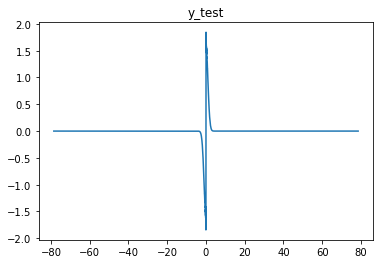

57


In [17]:
N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)
x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data()

px = stats.norm.pdf(x_test, loc=0, scale=1) # write the  function 
px = np.reshape(px, (N_test,1))

w0, var_f = method_1_w0(x_test, y_test, px)
print(w0)

In [18]:
class Compute_SB_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):

        # predicting the data
        pred = model.predict(x_test)
        pred = np.reshape(pred, (N_test, 1))

        FVU, SB = method_1(var_f, w0, x_test, y_test, pred, px)
        
        i = int(epoch -1)
        FVU_list[i] = FVU
        SB_list[i] = SB 
        #print(SB)

In [25]:
N_epoch = 100
FVU_list = np.zeros(N_epoch)
SB_list = np.zeros(N_epoch)

tf.random.set_seed(seed)
SB_callback = Compute_SB_Callback()
beta = model.fit(x_train, y_train, epochs=N_epoch, batch_size=32, callbacks=[SB_callback])

Epoch 1/100
128/128 [==============================] - 0s 3ms/step - loss: 2.6574e-04
Epoch 2/100
128/128 [==============================] - 0s 3ms/step - loss: 2.7581e-04
Epoch 3/100
128/128 [==============================] - 0s 3ms/step - loss: 3.0057e-04
Epoch 4/100
128/128 [==============================] - 0s 3ms/step - loss: 2.7069e-04
Epoch 5/100
128/128 [==============================] - 0s 3ms/step - loss: 3.0465e-04
Epoch 6/100
128/128 [==============================] - 0s 3ms/step - loss: 2.6581e-04
Epoch 7/100
128/128 [==============================] - 0s 3ms/step - loss: 4.8442e-04
Epoch 8/100
128/128 [==============================] - 0s 3ms/step - loss: 4.4912e-04
Epoch 9/100
128/128 [==============================] - 0s 3ms/step - loss: 2.5551e-04
Epoch 10/100
128/128 [==============================] - 0s 3ms/step - loss: 2.6868e-04
Epoch 11/100
128/128 [==============================] - 0s 3ms/step - loss: 2.5212e-04
Epoch 12/100
128/128 [==============================

https://www.tensorflow.org/guide/keras/custom_callback

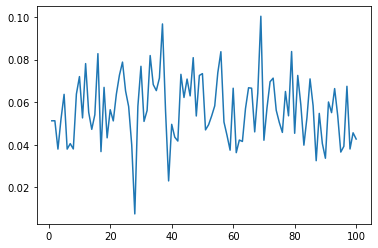

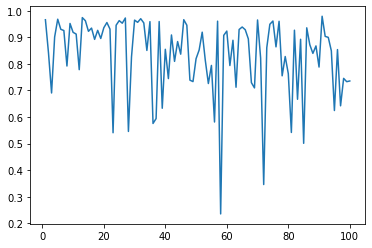

In [26]:
epoch_list = np.arange(1,N_epoch+1)

plt.plot(epoch_list, FVU_list)
plt.show()
plt.plot(epoch_list, SB_list)
plt.show()